In [1]:
from detectors import *
import numpy as np

In [2]:
data_version = '6-100-conf-70'
data_file = '../data/data-%s.csv'%(data_version)
label_file = '../data/label-%s.csv'%(data_version)
label_noised_file = '../data/label-noised-%s.csv'%(data_version)

X = np.loadtxt(data_file, delimiter=",")
y = np.loadtxt(label_file, delimiter=",")
y_noised = np.loadtxt(label_noised_file, delimiter=",")

In [3]:
print("X shape ", X.shape, " y shape ", y.shape, " y noised shape ", y_noised.shape)

X shape  (600,)  y shape  (600,)  y noised shape  (600,)


In [4]:
X, y, y_noised = X.reshape((-1, 1)), y.reshape((-1, 1)), y_noised.reshape((-1, 1))

# Inspection

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


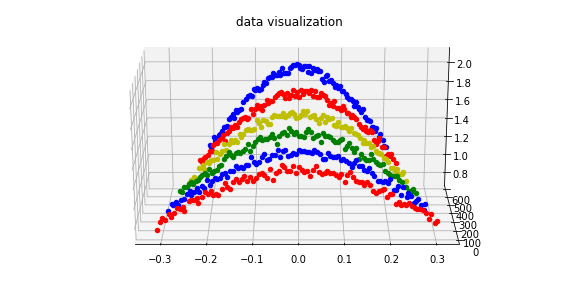

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("data visualization")
n = X.shape[0]
counter = 0
colors = ['r', 'b', 'g', 'y']
n_colors = len(colors)
for a, b, c in zip(X, y_noised, range(n-1)):
    ax.scatter(a, c, b, c=colors[int(counter/100)%n_colors], marker='o')
    counter += 1

ax.view_init(20, 270)

# Building detectors

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

def get_new_model(X, y, base_model=SVR):
    new_model = base_model()
    new_model.fit(X, y.ravel())
    return new_model


In [8]:
# creates set of detectors
# win_lens = [10*(i+1) for i in range(10)]
# wrn_bds = [1.5, 1.75, 2, 2.5]
# dtc_bds = [2.75, 3, 3.5, 4]
# wrn_bds = [1.25, 1.75, 2, 2.5, 2.75]
# dtc_bds = [3, 3.5, 4, 4.5, 5]
win_lens = [15*(i+1) for i in range(5)]
wrn_bds = np.arange(1.25, 2.75, 0.25).tolist()
dtc_bds = np.arange(2.95, 5, 0.25).tolist()


In [9]:
detectors_set = DetectorsSet(win_lens, wrn_bds, dtc_bds)

In [11]:
drift_number = 6
concept_len = 100
detectors_outputs = []
curr_model = None
train_size = 50
tolerance = 0.2

curr_model = get_new_model(X[:train_size], y_noised[:train_size])
for i in range(X.shape[0] + int(tolerance*concept_len)):
    
    if i % concept_len == int(tolerance*concept_len) and int(i/concept_len) > 0:
        concept_n = int(i/concept_len)
        start_idx_train = int(concept_n * concept_len)
        X_train = X[start_idx_train: start_idx_train + train_size]
        y_train = y_noised[start_idx_train: start_idx_train + train_size]
        print(i, concept_n, start_idx_train, y_train.shape)
        new_model = get_new_model(X_train, y_train)
        detectors_set.reset_detectors(new_model)
        
    if i >= X.shape[0]:
            next_sample, next_label = X[i - X.shape[0]], y[i - X.shape[0]]
    else:
        next_sample, next_label = X[i], y[i]   
        
    curr_pred = curr_model.predict([next_sample])
    detectors_prediction = detectors_set.predict(next_sample, curr_pred, next_label)
    detectors_outputs.append(detectors_prediction)
    
out = np.array(detectors_outputs)  
print('output shape ', out.shape)

120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
420 4 400 (50, 1)
520 5 500 (50, 1)
output shape  (620, 270)


In [12]:
hist = []
for l in detectors_outputs:
    z, w, d = 0, 0, 0
    for e in l:
        if e == 1:
            w += 1
        elif e == 2:
            d += 1
        else:
            z += 1
    hist.append([z, w, d])
    
def print_hist(start, end, hist):
    rg = end - start + 1
    for i in range(rg):
        print('it %d : ras %d, wrn %d, dtc %d'%(i, hist[start + i][0], hist[start + i][1], hist[start + i][2]))

In [13]:
def plot_concept_perf(out, concept_number, concept_len, tolerance, subplot=111):
    
    ay = range(out.shape[1])
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(subplot, projection='3d')
    ax.set_title("data visualization")
    colors = ['g', 'b', 'r']
    size_samples = int(concept_len*tolerance)
    for i in range(size_samples):
        idx = concept_number*size_samples + i
        if idx >= len(out):
            idx = i
        for dj in range(out.shape[1]):
            ax.scatter(i, dj, out[idx, dj],
                       c=colors[out[idx, dj]], marker='o')

    ax.view_init(20, 270)

In [14]:
def plot_concept_range(out, start, end, subplot=111):
    
    ay = range(out.shape[1])
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(subplot, projection='3d')
    ax.set_title("data visualization")
    colors = ['g', 'b', 'r']
    size_samples = end-start+1
    for i in range(size_samples):
        idx = start + i
        if idx >= len(out):
            idx = i
        for dj in range(out.shape[1]):
            ax.scatter(i, dj, out[idx, dj],
                       c=colors[out[idx, dj]], marker='o')

    ax.view_init(20, 270)

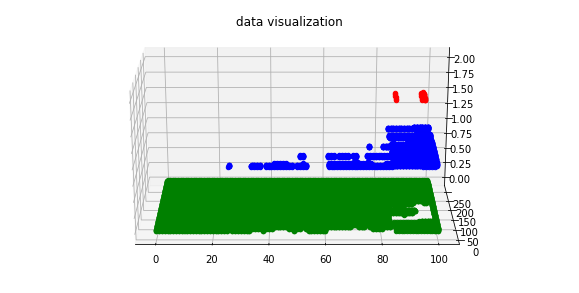

In [95]:
plot_concept_range(out, 120, 220)

In [138]:
print_hist(520, 619, hist)

it 0 : ras 540, wrn 0, dtc 0
it 1 : ras 540, wrn 0, dtc 0
it 2 : ras 540, wrn 0, dtc 0
it 3 : ras 540, wrn 0, dtc 0
it 4 : ras 540, wrn 0, dtc 0
it 5 : ras 540, wrn 0, dtc 0
it 6 : ras 540, wrn 0, dtc 0
it 7 : ras 540, wrn 0, dtc 0
it 8 : ras 540, wrn 0, dtc 0
it 9 : ras 540, wrn 0, dtc 0
it 10 : ras 540, wrn 0, dtc 0
it 11 : ras 513, wrn 27, dtc 0
it 12 : ras 531, wrn 9, dtc 0
it 13 : ras 505, wrn 35, dtc 0
it 14 : ras 505, wrn 35, dtc 0
it 15 : ras 513, wrn 27, dtc 0
it 16 : ras 513, wrn 27, dtc 0
it 17 : ras 505, wrn 35, dtc 0
it 18 : ras 513, wrn 27, dtc 0
it 19 : ras 513, wrn 27, dtc 0
it 20 : ras 513, wrn 27, dtc 0
it 21 : ras 540, wrn 0, dtc 0
it 22 : ras 540, wrn 0, dtc 0
it 23 : ras 540, wrn 0, dtc 0
it 24 : ras 540, wrn 0, dtc 0
it 25 : ras 540, wrn 0, dtc 0
it 26 : ras 468, wrn 42, dtc 30
it 27 : ras 471, wrn 57, dtc 12
it 28 : ras 456, wrn 72, dtc 12
it 29 : ras 468, wrn 72, dtc 0
it 30 : ras 459, wrn 81, dtc 0
it 31 : ras 468, wrn 72, dtc 0
it 32 : ras 468, wrn 72, dtc 0
i

# Dataset exctraction

In [15]:
def cd_detected(pred_vec):
    for val in pred_vec:
        if val == 2:
            return True
    return False

In [16]:
X, y = [], []
tol = 0.20
for i, x in enumerate(detectors_outputs):
    curr_concept_pos = i % concept_len 
    if cd_detected(x):
        X.append(x[:])
        if int(i/concept_len) > 0 and curr_concept_pos < tolerance * concept_len:
            y.append(1)
        else:
            y.append(0)

In [17]:
print(len(X), sum(y))

101 31


# Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [19]:
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
models_name = ['SVC', 'RF', 'KNN', 'LR']
base_models = {'SVC': SVC,
               'KNN':KNeighborsClassifier,
               'LR':LogisticRegression,
               'RF':RandomForestClassifier}
models = []
print('training models')
for model_name in models_name:
    print('training %s ...'%model_name)
    model = base_models[model_name]()
    model.fit(X_train, y_train)
    models.append(model)

training models
training SVC ...
training RF ...
training KNN ...
training LR ...


In [21]:
print("testing model")
best_model = models[0]
best_score = 0
for i in range(len(models)):
    model = models[i]
    pred = model.predict(X_test)
    score = f1_score(y_pred=pred, y_true=y_test)
    best_model = best_model if best_score >= score else model
    best_score = best_score if best_score >= score else score
    print('score %s %f'%(models_name[i], score)) 
    

testing model
score SVC 0.000000
score RF 0.444444
score KNN 0.250000
score LR 0.545455


/Users/sathouel/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
